# 1 GP Optimization of a Toy Problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
from matplotlib import cm
from scipy.stats import norm
import GPy
import optunity
from sobol import i4_uniform, i4_sobol

1) Implementation of $f(x,y)$ and plotting it in the rectangle $[-6,6]^2$ using matplotlib

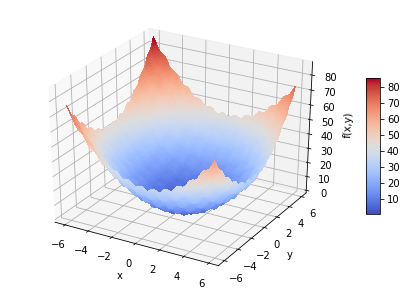

In [3]:
#function
def f(x,y):
    return x**2-x+y**2+y-np.cos(2*np.pi*x-np.pi)-np.cos(2*np.pi*y+np.pi)+2.5

#plotting function in rectrangle [-6,6]^2
l = -6
u = 6
x = np.arange(l, u, 0.1)
y = np.arange(l, u, 0.1)
X, Y = np.meshgrid(x, y)

Z = f(X,Y)

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
fig.colorbar(surf, shrink = 0.5, aspect = 10)
plt.show()

2) Use a utitity function to estimate how useful a point $q=(x,y)$ might be in order to find the desired optimum.
A popular choice in the field of Bayesian optimization is Expected Improvement:
$$ u(q,E_{best}) = \sqrt{Var(q)}(\gamma (q) \Phi (\gamma (q)) + \phi ( \gamma (q)) $$
with $\gamma (q) = \frac{E_{best} - E(q)}{\sqrt{Var (q)}}$. Here $E(q)$ and $Var(q)$ are estimates of the mean and variance of the target function, as returned by the Gaussian process model at point $q, \, E_{best}$ is our current best guess of the target function's minimal value, and $\Phi$ and $\phi$ are the cdf and pdf of the normal distribution

In [4]:
def gamma(E_mean, E_best, var_q):
    return (E_best - E_mean)/np.sqrt(var_q)

def Phi(q):
    return norm.cdf(q)

def phi(q):
    return norm.pdf(q)

class expected_improvement:
    def __init__(self, E_best, model):
        self.E_best = E_best
        self.model = model
        
    def foo(self, x,y):
        E_best = self.E_best
        model = self.model
        var_q = model.predict(np.array([[x,y]]))[1][0][0]
        E_mean = model.predict(np.array([[x,y]]))[0][0][0]
        q = np.asarray([x,y])
        return np.sqrt(var_q) * (gamma(E_mean, E_best, var_q) * Phi(gamma(E_mean, E_best, var_q)) + phi(gamma(E_mean, E_best, var_q)))

3) Creating an initial set of 30 training points $Q \in R^{2 \times 30}$ by drawing semi-random locations from a sobol sequece

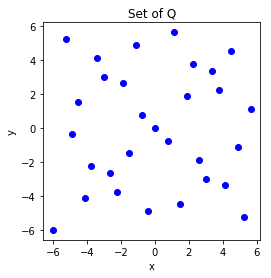

In [5]:
def create_training_points(N=30):
    number_of_samples = 30
    parameterUpperLimits = np.array([6,6])
    parameterLowerLimits = np.array([-6,-6])
    Q = [[],[]]
    for i in range(number_of_samples):
        x,y = i4_sobol(2,i)[0] * (parameterUpperLimits- parameterLowerLimits) + parameterLowerLimits
        Q[0].append(x)
        Q[1].append(y)
    return np.asarray(Q)
    
Q = create_training_points()

plt.axes(aspect='equal')
plt.plot(Q[0],Q[1], 'bo')
plt.title('Set of Q')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

4) Creating the initial training set by computing the true function values $E=\{f(x,y):(x,y) \in Q\} $

(30, 2) (30, 1)


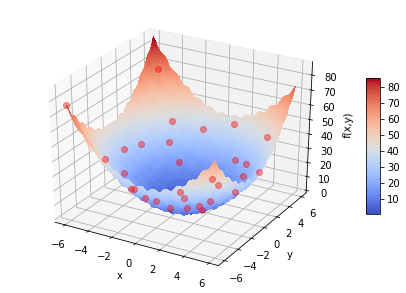

In [7]:
def create_training_set(Q):
    E = f(Q[0], Q[1])
    E_ = []
    Q_input = np.zeros(shape=(30))
    Q_input = Q_input.tolist()
    for i in range(len(Q[0])):
        Q_input[i] = [Q[0][i],Q[1][i]]
        E_.append([E[i]])

    E_ = np.asarray(E_)
    Q_input = np.asarray(Q_input)
    return E_, Q_input 

E_ , Q_input = create_training_set(Q)

print(np.shape(Q_input), np.shape(E_))

# -------------------------------------------------

# plotting function in rectrangle [-6,6]^2
l = -6
u = 6
x = np.arange(l, u, 0.1)
y = np.arange(l, u, 0.1)
X, Y = np.meshgrid(x, y)

X_q = np.asarray([Q_input[i][0] for i in range(len(Q_input))])
Y_q = np.asarray([Q_input[i][1] for i in range(len(Q_input))])
Z_q = f(X_q, Y_q)

Z = f(X,Y)

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_q, Y_q, Z_q, 'ro', alpha=0.4)
surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
fig.colorbar(surf, shrink = 0.5, aspect = 10)
plt.show()

5) Using the GPy module to train a GP model GPy.models.GPRegression for the current training set, using the kernel GPy.kern.RBF(2) + GPy.kern.White(2

In [8]:
kern = GPy.kern.RBF(2) + GPy.kern.White(2)

model = GPy.models.GPRegression(Q_input, E_, kernel=kern)
print(model)


Name : GP regression
Objective : 4503.41399233135
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |    1.0  |      +ve      |        
  sum.white.variance       |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


6) Using the Optunity module to find the point $q = (x,y) \in [-6,6]^2$ which maximizes the expected improvement $u(q,E_{best})$.

In [9]:
def maximize_expected_improvement(E, model, print_=False):
    e = expected_improvement(np.min(E), model)
    
    maximum = optunity.maximize(e.foo, x = [-6,6], y=[-6,6])
    x = maximum[0]['x']
    y = maximum[0]['y']
    
    if print_ == True:
        print('x: ', x, 'y: ', y)
    return x, y

x_max, y_max = maximize_expected_improvement(E_, model, print_=True)

x:  0.5088894340771313 y:  -1.5602343750000003


7) Evaluation of $f(q=(x,y))$ at the new candidate point and addition of $(q,f(q))$ to the training set $Q$

In [10]:
def evaluate_new_point_and_add_to_training_set(q, Q_input, E):
    x = q[0]
    y = q[1]
    
    Q_input = Q_input.tolist()
    Q_input.append([x,y])
    E = E.tolist()
    E.append([f(x,y)])
    Q_input = np.asarray(Q_input)
    E = np.asarray(E)
    return Q_input, E


E = E_
print(np.shape(Q_input), np.shape(E))

(30, 2) (30, 1)


8) 

In [11]:
def repeat_steps(N, Q_input, E_, print_ = True, return_prediction=False):
    kern = GPy.kern.RBF(2) + GPy.kern.White(2)
    print(np.shape(Q_input), np.shape(E_))
    for i in range(N):
        model = GPy.models.GPRegression(Q_input, E_, kernel=kern)
        x_max, y_max = maximize_expected_improvement(E_, model)
        Q_input, E_ = evaluate_new_point_and_add_to_training_set([x_max,y_max], Q_input, E_)
        
        if print_ == True:
            print('iteration: ', i)
            print('True fct values: ', [f(Q_input[i][0],Q_input[i][1]) for i in range(len(Q_input))])
            print('Regression val.: ', [model.predict(np.asarray(Q_input))[0][i][0] for i in range(len(Q_input))])
            print('')
    if return_prediction == True:
        return Q_input, E_, [model.predict(np.asarray(Q_input))[0][i][0] for i in range(len(Q_input))]
    return Q_input, E_
        
Q_input, E, prediction = repeat_steps(30, Q_input, E,print_=True, return_prediction= True)
print(np.shape(Q_input), np.shape(E), np.shape(prediction))

(30, 2) (30, 1)
iteration:  0
True fct values:  [76.5, 4.5, 16.5, 28.5, 5.0, 41.0, 17.0, 29.0, 23.124999999999996, 23.124999999999996, 47.125, 5.1249999999999991, 20.125, 20.125, 2.125, 68.125, 30.90625, 39.906249999999993, 23.40625, 17.40625, 21.90625, 30.90625, 8.40625, 38.40625, 37.945463562373092, 10.945463562373094, 22.945463562373092, 34.945463562373092, 14.867036437626904, 23.867036437626908, 4.8999304260624772]
Regression val.:  [25.73233455375421, 2.2890444956288478, 8.7807288920908739, 15.273854056163188, 2.7708363481881921, 15.03260750490375, 6.7750574817046649, 11.34202889494083, 10.80001959303917, 11.265110545505614, 16.122094697190359, 2.5122208649394842, 9.6959154683914868, 10.150044024936843, 1.4264886579504328, 23.389928267871014, 11.644901064178839, 14.143298738519897, 10.492981291136239, 9.3608117760342484, 8.1875434643823759, 10.934059662340051, 4.9069540358510926, 17.174186385814988, 14.556200928681736, 5.2180898645414446, 8.4615870641476825, 12.891743715350065, 9.

iteration:  8
True fct values:  [76.5, 4.5, 16.5, 28.5, 5.0, 41.0, 17.0, 29.0, 23.124999999999996, 23.124999999999996, 47.125, 5.1249999999999991, 20.125, 20.125, 2.125, 68.125, 30.90625, 39.906249999999993, 23.40625, 17.40625, 21.90625, 30.90625, 8.40625, 38.40625, 37.945463562373092, 10.945463562373094, 22.945463562373092, 34.945463562373092, 14.867036437626904, 23.867036437626908, 4.8999304260624772, 3.3842083779005563, 4.1499009611874635, 10.778221666407232, 7.3606212036132792, 3.3270973477207342, 5.5505079591004716, 5.7837111467208988, 1.2001526473364104]
Regression val.:  [25.732345733194517, 2.7602495882012779, 8.7641209468490242, 15.270527362720257, 3.5343590165756416, 15.033687094663874, 6.8035129737341613, 11.378318127207958, 10.822029124687539, 11.265969952401628, 16.122338112489629, 3.5041397096439293, 9.6958663779362784, 10.164605145825744, 2.520761525133373, 23.390039759005383, 11.680121602740344, 14.143747898743479, 10.485542143653211, 9.4869616617482482, 8.2054203700700


iteration:  14
True fct values:  [76.5, 4.5, 16.5, 28.5, 5.0, 41.0, 17.0, 29.0, 23.124999999999996, 23.124999999999996, 47.125, 5.1249999999999991, 20.125, 20.125, 2.125, 68.125, 30.90625, 39.906249999999993, 23.40625, 17.40625, 21.90625, 30.90625, 8.40625, 38.40625, 37.945463562373092, 10.945463562373094, 22.945463562373092, 34.945463562373092, 14.867036437626904, 23.867036437626908, 4.8999304260624772, 3.3842083779005563, 4.1499009611874635, 10.778221666407232, 7.3606212036132792, 3.3270973477207342, 5.5505079591004716, 5.7837111467208988, 1.2001526473364104, 39.982854883495584, 1.0058600086343037, 0.29170057967298835, 1.2012937339680219, 1.4534781236358101, 3.912719980596707]
Regression val.:  [25.738127299976934, 2.1556740067114197, 8.767926590008349, 15.270186942396363, 3.4878415065254154, 15.033683538940872, 6.7660295619248645, 11.378282717527062, 10.800684570751104, 11.265863673812321, 16.122339975630876, 3.4238486821121108, 10.463614246252735, 10.165942138959016, 1.78394002955

Regression val.:  [25.738127102903348, 2.1787249937925508, 8.7660685143476584, 15.270168111089468, 3.4817858914962732, 15.033673800153743, 6.7652316226938867, 11.378291870039529, 10.800826074618616, 11.266015314600294, 16.12236463862196, 3.4174267926352959, 10.463218483829781, 10.165958197193135, 1.9846795432641893, 23.39004219247267, 11.680914132387009, 14.143748835129582, 10.484790983742334, 9.490446508200522, 8.9796939557542732, 10.935882459962606, 5.2443706667040493, 17.170290434708196, 14.82201342170212, 5.8069206625694898, 8.4801005089260855, 12.893219538826738, 9.7113040944745439, 14.281135743859656, 2.9766752907736853, 2.6022505785374705, 3.0445590019492013, 4.4600448455983148, 3.6281596604598016, 2.1269442154859228, 2.983133424223841, 3.1968371465488352, 2.2729110431351143, 14.324600120342081, 1.896318953938585, 1.8407526354281103, 1.8794902725257259, 1.8674666707380729, 2.1526641403800006, 2.0260934476921761, 1.8852422429739701, 1.9350204833408755, 1.9088633969121818, 1.82567

iteration:  25
True fct values:  [76.5, 4.5, 16.5, 28.5, 5.0, 41.0, 17.0, 29.0, 23.124999999999996, 23.124999999999996, 47.125, 5.1249999999999991, 20.125, 20.125, 2.125, 68.125, 30.90625, 39.906249999999993, 23.40625, 17.40625, 21.90625, 30.90625, 8.40625, 38.40625, 37.945463562373092, 10.945463562373094, 22.945463562373092, 34.945463562373092, 14.867036437626904, 23.867036437626908, 4.8999304260624772, 3.3842083779005563, 4.1499009611874635, 10.778221666407232, 7.3606212036132792, 3.3270973477207342, 5.5505079591004716, 5.7837111467208988, 1.2001526473364104, 39.982854883495584, 1.0058600086343037, 0.29170057967298835, 1.2012937339680219, 1.4534781236358101, 3.912719980596707, 2.2505213995705047, 1.7329784871562659, 1.6745393368652277, 1.9374783865277614, 0.093108733289610335, 1.4530281069803186, 1.0554683253793087, 2.3341662866307344, 1.244277965279422, 46.141539180803306, 0.35558864512653177]
Regression val.:  [25.753529351722602, 2.06510743838153, 8.7659329790899712, 15.2711647930

iteration:  29
True fct values:  [76.5, 4.5, 16.5, 28.5, 5.0, 41.0, 17.0, 29.0, 23.124999999999996, 23.124999999999996, 47.125, 5.1249999999999991, 20.125, 20.125, 2.125, 68.125, 30.90625, 39.906249999999993, 23.40625, 17.40625, 21.90625, 30.90625, 8.40625, 38.40625, 37.945463562373092, 10.945463562373094, 22.945463562373092, 34.945463562373092, 14.867036437626904, 23.867036437626908, 4.8999304260624772, 3.3842083779005563, 4.1499009611874635, 10.778221666407232, 7.3606212036132792, 3.3270973477207342, 5.5505079591004716, 5.7837111467208988, 1.2001526473364104, 39.982854883495584, 1.0058600086343037, 0.29170057967298835, 1.2012937339680219, 1.4534781236358101, 3.912719980596707, 2.2505213995705047, 1.7329784871562659, 1.6745393368652277, 1.9374783865277614, 0.093108733289610335, 1.4530281069803186, 1.0554683253793087, 2.3341662866307344, 1.244277965279422, 46.141539180803306, 0.35558864512653177, 2.5383364356323783, 3.8706349763458983, 32.750217371983396, 0.88161852570102672]
Regressio

9) Mark the gloabal optimum and the points in your final training set $Q$ in the plot from step 1) 

(120, 120) (120, 120)


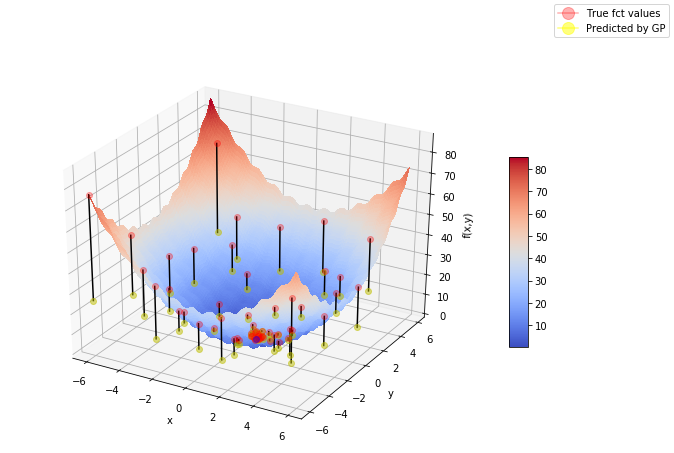

In [12]:
# plotting function in rectrangle [-6,6]^2
def plot_data(Q_input, prediction, l= -6 , u = 6):
    x = np.arange(l, u, 0.1)
    y = np.arange(l, u, 0.1)
    X, Y = np.meshgrid(x, y)

    X_q = np.asarray([Q_input[i][0] for i in range(len(Q_input))])
    Y_q = np.asarray([Q_input[i][1] for i in range(len(Q_input))])
    Z_q = f(X_q, Y_q)

    Z_GP = prediction

    Z = f(X,Y)
    print(np.shape(Z), np.shape(X))
    

    fig = plt.figure(figsize=(7.5*1.4,5*1.4))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(X_q)):
        ax.plot([X_q[i],X_q[i]],[Y_q[i], Y_q[i]],[Z_q[i], Z_GP[i]], color='black')

    ax.plot(X_q, Y_q, Z_GP, 'yo', alpha=0.5, label='Predicted by GP')
    ax.plot(X_q, Y_q, Z_q, 'ro', alpha=0.3, label='True fct values')
    ax.plot([0.5], [-0.5], [0], 'bo', alpha=0.4)
    surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x,y)')

    import matplotlib.lines as mlines
    red_dot = mlines.Line2D([], [], color='red', alpha=0.3, marker='o', markersize=12)
    yellow_dot = mlines.Line2D([], [], color='yellow', alpha=0.5, marker='o', markersize=12)
    fig.legend(handles=[red_dot, yellow_dot], labels=['True fct values','Predicted by GP'])
    fig.colorbar(surf, shrink = 0.5, aspect = 10)

    plt.show()
    
plot_data(Q_input, prediction)

10) Repeat the experiment, but alternate between two utility functions in consecutive iterations: maximal expected improvement and maximal variance of the GPy model.

In [13]:
# construct the inital training set
E_ , Q_input = create_training_set(Q)
print(np.shape(E_), np.shape(Q_input))

(30, 1) (30, 2)


In [15]:
class get_variance:
    def __init__(self, model):
        self.model = model
    
    def func(self, x, y):
        model = self.model
        return model.predict(np.array([[x,y]]))[0][0][0]

def maximize_variance(model, print_ = False):
    var = get_variance(model)
    max_var = optunity.maximize(var.func, x = [-6,6], y = [-6,6])
    x = max_var[0]['x']
    y = max_var[0]['y']
    #print(maximum)
    if print_ == True:
        print('x: ', x, 'y: ', y)
    return x, y

def maximize_expected_improvement(E, model, print_=False):
    e = expected_improvement(np.min(E), model)
    #E_best = np.min(E)
    maximum = optunity.maximize(e.foo, x = [-6,6], y = [-6,6])
    x = maximum[0]['x']
    y = maximum[0]['y']
    #print(maximum)
    if print_ == True:
        print('x: ', x, 'y: ', y)
    return x, y

def repeat_consecutive_steps(N, Q_input, E_, print_ = True, return_prediction=False):
    kern = GPy.kern.RBF(2) + GPy.kern.White(2)
    print(np.shape(Q_input), np.shape(E_))
    for i in range(N//2):
        model = GPy.models.GPRegression(Q_input, E_, kernel=kern)
        x_max, y_max = maximize_expected_improvement(E_, model)
        Q_input, E_ = evaluate_new_point_and_add_to_training_set([x_max,y_max], Q_input, E_)
        
        model = GPy.models.GPRegression(Q_input, E_, kernel=kern)
        x_max, y_max = maximize_variance(model)
        Q_input, E_ = evaluate_new_point_and_add_to_training_set([x_max,y_max], Q_input, E_)
        
        if print_ == True:
            print('iteration: ', i)
            print('True fct values: ', [f(Q_input[i][0],Q_input[i][1]) for i in range(len(Q_input))])
            print('Regression val.: ', [model.predict(np.asarray(Q_input))[0][i][0] for i in range(len(Q_input))])
            print('')
    if return_prediction == True:
        return Q_input, E_, [model.predict(np.asarray(Q_input))[0][i][0] for i in range(len(Q_input))]
    return Q_input, E_
        
Q_input, E, prediction = repeat_consecutive_steps(30, Q_input, E_,print_=False, return_prediction= True)
print(np.shape(Q_input), np.shape(E), np.shape(prediction))

(30, 2) (30, 1)
(60, 2) (60, 1) (60,)


(120, 120) (120, 120)


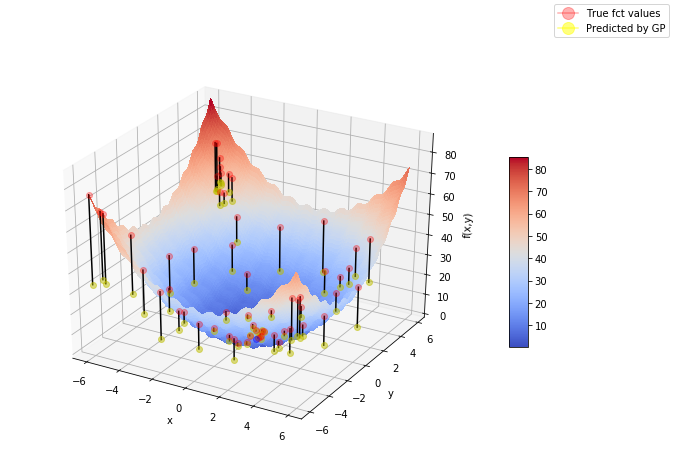

In [16]:
plot_data(Q_input, prediction)

Randompoints evaluated with f(x,y)
(120, 120) (120, 120)


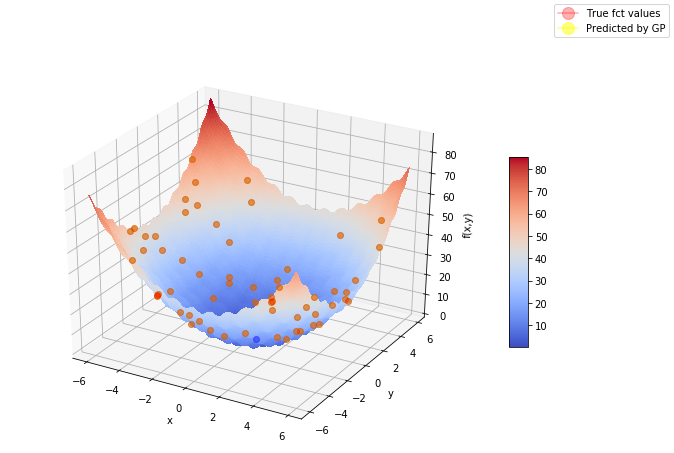

In [17]:
def create_random_set(N):
    return np.random.ranf(size=(N,2))*12-6

random_Q = create_random_set(60)
print('Randompoints evaluated with f(x,y)')
plot_data(random_Q, f(np.asarray([random_Q[i][0] for i in range(len(random_Q))]), np.asarray([random_Q[i][1] for i in range(len(random_Q))])))

In [18]:
print('Minimal value archived with random points guessing and evaluating with f: ',np.min(f(np.asarray([random_Q[i][0] for i in range(len(random_Q))]), np.asarray([random_Q[i][1] for i in range(len(random_Q))]))))
X_q = np.asarray([Q_input[i][0] for i in range(len(Q_input))])
Y_q = np.asarray([Q_input[i][1] for i in range(len(Q_input))])
print('Minimal value archived with the above algorithm and evaluating with f: ', np.min(f(X_q, Y_q)))

Minimal value archived with random points guessing and evaluating with f:  2.50389922762
Minimal value archived with the above algorithm and evaluating with f:  0.951589186096


11) Plotting GP's approximation for $f(x,y)$ before and after optimization

With initial 30 points: 


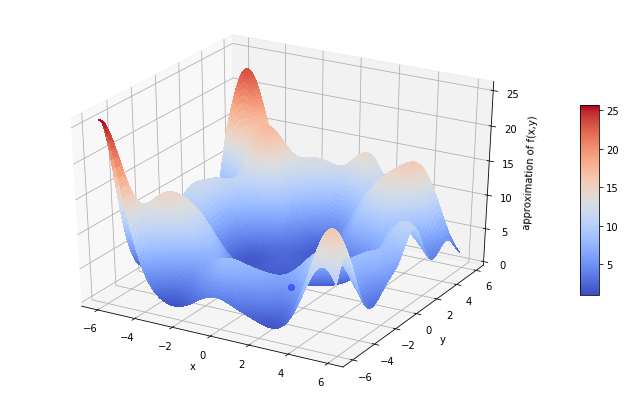

With 60 optimally chosen points: 
(30, 2) (30, 1)


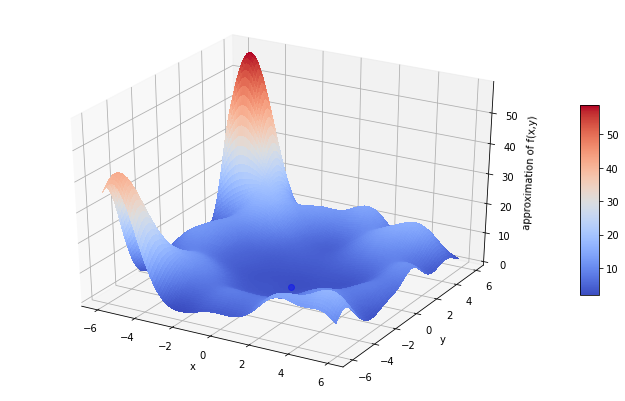

In [19]:
def plot_approximation_function(Q_input, E_, l = -6, u = 6):
    model = GPy.models.GPRegression(Q_input, E_, kernel=kern)
    x = np.arange(l, u, 0.1)
    y = np.arange(l, u, 0.1)
    
    Z = [[model.predict(np.asarray([[x[i],y[j]]]))[0][0][0] for i in range(len(x))] for j in range(len(y))]

    fig = plt.figure(figsize=(7.5*1.6,5*1.4))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot([0.5], [-0.5], [0], 'bo', alpha=0.4)
    surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('approximation of f(x,y)')
    fig.colorbar(surf, shrink = 0.5, aspect = 10)

    plt.show()

print('With initial 30 points: ')
E_ , Q_input = create_training_set(Q)
plot_approximation_function(Q_input, E_)
print('With 60 optimally chosen points: ')
Q_input, E, prediction = repeat_consecutive_steps(30, Q_input, E_ ,print_=False, return_prediction= True)
plot_approximation_function(Q_input, E)

2 Reconstruction of a Corrupted Image

In [26]:
import numpy as np
import sys
import argparse
from scipy.misc import imread, imsave
import numpy
import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial
import imageio

def gnrlexp_kernel(data, p, gamma):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    

    # Find the pairwise squared distances and compute the Gaussian kernel.
    distances_modified = []
    for k in data:
        d_modified = np.sqrt(np.sum((data-k)**2,axis=1)/(p**2))
        distances_modified.append(d_modified)
    K = np.exp(np.around((-1*np.array(distances_modified)**gamma),decimals=2))
    K = scipy.sparse.csr_matrix(K) 
    return K



def compute_alpha(train_x, train_y, tau):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :return: alpha vector
    """
    print ("building input kernel matrix")
    K = gnrlexp_kernel(train_x, p=3.0, gamma=4.0)
    print ("sparsity: %.2f%%" % (float(100*K.nnz) / (K.shape[0]*K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:,None])
    print ("solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    print ("done computing alpha")
    return alpha[0]

class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau,sigma=2):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma


    def train(self, train_x, train_y):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(numpy.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = numpy.asarray(self.tree.query_ball_point(pred_x,self.max_distance), dtype=np.dtype("i8"))
        dist = numpy.sum((self.train_x[indices]-pred_x)**2, axis=1)
        kappa = numpy.exp(self.scale*dist)
        pred_y = numpy.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(numpy.float32)
        return numpy.array([self.predict_single(x) for x in pred_x])


def kernel_ridge_regression(tau):
    # Load the image.
    im_orig = numpy.squeeze(imageio.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = numpy.array(im_orig)
    # Find the known pixels and the pixels that shall be predicted.
    known_ind = numpy.where(im != 0)
    unknown_ind = numpy.where(im == 0)
    known_x = numpy.array(known_ind).transpose()
    known_y = numpy.array(im[known_ind])
    pred_x = numpy.array(unknown_ind).transpose()
    # Train and predict with the given regressor.
    start = time.time()
    print ("training...")
    r = KernelRidgeRegressor(tau)
    r.train(known_x, known_y)
    print ("done training")
    # pickle.dump(r, open("regressor.p", "wb"))
    # r = pickle.load(open("regressor.p", "rb"))
    print ("predicting...")
    pred_y = r.predict(pred_x)
    print ("done predicting")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    print ("Train and predict took %.02f seconds." % (stop-start))
    imageio.imwrite("task2.png", im)


def main(tau):
    """Call the exercises.
    """
    # Read the command line arguments.
    kernel_ridge_regression(tau)

main(0.8)


training...
building input kernel matrix
sparsity: 0.35%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 10.88 seconds.


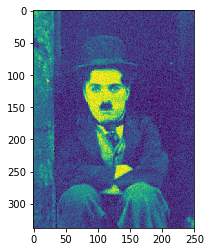

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
original = mpimg.imread("charlie-chaplin.jpg")
img = plt.imshow(original)

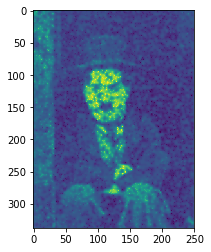

In [27]:
created = imageio.imread("task2.png")
plt.imshow(created)

Bayesian Optimization of Hyperparameters

In [20]:
import sys
import argparse
from scipy.misc import imread, imsave
import numpy
import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial
import imageio
import numpy as np
import sobol
import optunity
import GPy




def corr_function(A,B):
    A_centered = A-np.mean(A)
    B_centered = B-np.mean(B)
    AB_product = np.multiply(A_centered,B_centered)
    A_denom  = np.sum(A_centered**2)
    B_denom = np.sum(B_centered**2)
    corr_AB = np.sum(AB_product)/np.sqrt(A_denom*B_denom)
    print(corr_AB)
    return corr_AB


def kernel_ridge_regression(tau,p,gamma):
    # Load the image.
    im_orig = numpy.squeeze(imageio.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = numpy.array(im_orig)
    # Find the known pixels and the pixels that shall be predicted.
    known_ind = numpy.where(im != 0)
    unknown_ind = numpy.where(im == 0)
    known_x = numpy.array(known_ind).transpose()
    known_y = numpy.array(im[known_ind])
    pred_x = numpy.array(unknown_ind).transpose()
    # Train and predict with the given regressor.
    start = time.time()
    print ("training...")
    r = KernelRidgeRegressor(tau,p,gamma)
    r.train(known_x, known_y)
    print ("done training")
    # pickle.dump(r, open("regressor.p", "wb"))
    # r = pickle.load(open("regressor.p", "rb"))
    print ("predicting...")
    pred_y = r.predict(pred_x)
    print ("done predicting")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    print ("Train and predict took %.02f seconds." % (stop-start))
    imageio.imwrite("res.png", im)


class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau,p,gamma,sigma=4):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.p = p
        self.gamma = gamma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma

    def train(self, train_x, train_y):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(numpy.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau, self.p, self.gamma)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = numpy.asarray(self.tree.query_ball_point(pred_x, self.max_distance))
        dist = numpy.sum((self.train_x[indices]-pred_x)**2, axis=1)
        kappa = numpy.exp(self.scale*dist)
        pred_y = numpy.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(numpy.float32)
        return numpy.array([self.predict_single(x) for x in pred_x])

def compute_alpha(train_x, train_y, tau,p,gamma):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :return: alpha vector
    """
    print ("building input kernel matrix")
    K = gnrlexp_kernel(train_x, p, gamma)
    print ("sparsity: %.2f%%" % (float(100*K.nnz) / (K.shape[0]*K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:,None])
    print ("solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    print ("done computing alpha")
    return alpha[0]

def gnrlexp_kernel(data, p, gamma):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2

    # Find the pairwise squared distances and compute the Gaussian kernel.
    distances_modified = []
    for k in data:
        d_modified = np.sqrt(np.sum((data-k)**2,axis=1)/(p**2))
        distances_modified.append(d_modified)
    K = np.exp(np.around((-1*np.array(distances_modified)**gamma),decimals=2))
    K = scipy.sparse.csr_matrix(K) 
    return K



def inter_function(tau,p,gamma):
    kernel_ridge_regression(tau,p,gamma)
    im_orig = numpy.squeeze(imageio.imread("charlie-chaplin.jpg"))
    im = numpy.array(im_orig)
    im_orig2 = numpy.squeeze(imageio.imread("res.png"))
    im2 = numpy.array(im_orig2)
    
    corr_images = corr_function(im,im2)
    return 1-corr_images


number_of_samples = 30
sobol_samples = np.zeros((30,3))
parameterLowerLimits = np. array ([0.005,1,1])
parameterUpperLimits = np. array ([ 1,7,4])
for i in range ( number_of_samples ):
    x,y,z = sobol . i4_sobol (3,i)[0] * ( parameterUpperLimits -parameterLowerLimits ) + parameterLowerLimits
    sobol_samples[i,:] = np.array([x,y,z])
inv_correlation = np.zeros(30)
for i in range(0,30):
    invcorr_images = inter_function(sobol_samples[i,0],sobol_samples[i,1],sobol_samples[i,2])
    inv_correlation[i] = invcorr_images

train_q1 = sobol_samples


kernel_desired = GPy.kern.Matern52(3)
def mean_variance(q):
    gpy_est = GPy.models.GPRegression(train_q1,inv_correlation.reshape(-1,1),kernel=kernel_desired)
    return [gpy_est.predict(q)[0],gpy_est.predict(q)[1]]
E_best_cal = inv_correlation.reshape(-1,1)
E_best = np.min(E_best_cal)
def utility_function(tau,p,gamma):
        q = np.array([tau,p,gamma]).reshape(-1,3)
        gamma = ((E_best-mean_variance(q)[0])/np.sqrt(mean_variance(q))[1])
        return np.sqrt(mean_variance(q))[1]*(gamma*(scipy.stats.norm.pdf(gamma))+scipy.stats.norm.cdf(gamma))

true_values = []
guassian_values = []

def utility_function2(tau,p,gamma):
    q = np.array([tau,p,gamma]).reshape(-1,3)
    gpy_est = GPy.models.GPRegression(train_q1,inv_correlation.reshape(-1,1),kernel=kernel_desired)
    return gpy_est.predict(q)[1][0][0] 
  
for i in range(0,30):
        
    if i%2 ==1:
        pars = optunity.minimize(utility_function2,tau=[0.005,1],p=[1,7],gamma=[1,4])
    elif i%2==0:
        pars = optunity.minimize(utility_function,tau=[0.005,1],p=[1,7],gamma=[1,4])
    true_value=inter_function(np.around(pars[0]['tau'],decimals=2),np.around(pars[0]['p'],decimals=2),np.around(pars[0]['gamma'],decimals=2))
    print("true value:",true_value)
    true_values.append(true_value)
    gpy_est = GPy.models.GPRegression(train_q1,inv_correlation.reshape(-1,1),kernel=kernel_desired)
    gpy_prediction = gpy_est.predict(np.array([np.around(pars[0]['tau'],decimals=2),np.around(pars[0]['p'],decimals=2),np.around(pars[0]['gamma'],decimals=2)]).reshape(-1,3))[0][0][0]
    print("guassian value",gpy_prediction)
    guassian_values.append(gpy_prediction)
    train_q1 = np.vstack([train_q1,np.array([np.around(pars[0]['tau'],decimals=2),np.around(pars[0]['p'],decimals=2),np.around(pars[0]['gamma'],decimals=2)])]) 
    inv_correlation = np.append(inv_correlation,gpy_prediction)
    E_best_cal = np.append(E_best_cal,gpy_prediction)
    E_best = np.min(E_best_cal)

training...
building input kernel matrix
sparsity: 28.70%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.85 seconds.
0.07701523682214867
training...
building input kernel matrix
sparsity: 2.28%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.63 seconds.
0.38497906229697254
training...
building input kernel matrix
sparsity: 0.40%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 10.75 seconds.
-0.06298018875652292
training...
building input kernel matrix
sparsity: 17.76%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 13.69 seconds.
0.9179455550816111
training...
building input kernel matrix
sparsity: 0.96%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.01 seconds.
0.015426

training...
building input kernel matrix
sparsity: 1.10%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.26 seconds.
-0.07261883013232029
true value: 1.0726188301323203
guassian value 1.0192200707680514
training...
building input kernel matrix
sparsity: 1.66%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.29 seconds.
-0.07665733460153949
true value: 1.0766573346015396
guassian value 1.0066037399616135
training...
building input kernel matrix
sparsity: 0.59%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 11.28 seconds.
-0.09038514913471268
true value: 1.0903851491347127
guassian value 1.0231283058849119
training...
building input kernel matrix
sparsity: 1.26%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 13.89 seconds.
-0.08647110005

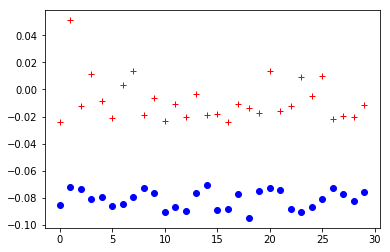

In [22]:
corr_true = 1-np.array(true_values)
corr_predicted = 1-np.array(guassian_values)
fig5 = plt.figure()
plt.plot(corr_true,'bo')
plt.plot(corr_predicted,'r+')
plt.show()


In [23]:
required_parameters = train_q1[np.where(inv_correlation == np.min(inv_correlation))[0]]
print("Parameters found",required_parameters)

Parameters found [[0.78234375 5.6875     2.96875   ]]


In [24]:
kernel_ridge_regression(required_parameters[0][0],required_parameters[0][1],required_parameters[0][2])

training...
building input kernel matrix
sparsity: 2.54%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 14.69 seconds.


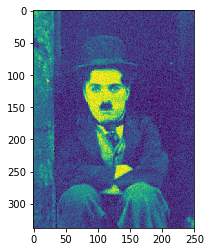

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
original = mpimg.imread("charlie-chaplin.jpg")
img = plt.imshow(original)

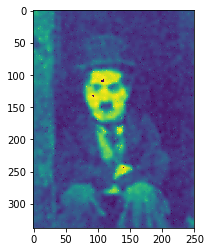

In [25]:
created = imageio.imread("res.png")
plt.imshow(created)